<a href="https://colab.research.google.com/github/Sudorenkoroma/HW_GI_ML/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
from google.colab import drive
import pywt
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [2]:
# завантажимо для зручності датасет на хмару
drive.mount('/content/drive')

data_directory = "/content/drive/MyDrive/Code/HW5/dataset/data"
activities = os.listdir(data_directory)
activities # список із імен файлів потім використаємо як мітки

Mounted at /content/drive


['idle', 'walking', 'running', 'stairs']

In [3]:
# вилучаємо дані
data_frames = []

for activity in activities:
    # ітераційно проходимо по кожній папкі
    files = glob(os.path.join(data_directory, activity, '*.csv'))
    for file in files: # проходимо по кожному файлу в папкі
        df = pd.read_csv(file)
        df['Activity'] = activity
        data_frames.append(df) # створюємо список з pd обєктів


In [4]:
# конкатинуємо список обєктів в одну таблицю pd
combined_data = pd.concat(data_frames, ignore_index=True)
combined_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,0.378284,-0.014365,9.744401,idle
1,0.459687,-0.043096,9.763555,idle
2,0.363919,0.014365,9.710882,idle
3,0.421380,-0.028730,9.758766,idle
4,0.435745,-0.062249,9.773131,idle


In [5]:
# Вхідні дані нормалізуються, щоб мати середнє значення нуль і стандартне відхилення одиниці
# Винесемо частину коду з нормалізацією в окремий блок, для можливості її відключити і спробувати без неї
data = combined_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]  # Вибірка числових колонок

# Створення об'єкту StandardScaler для нормалізації
scaler = StandardScaler()

# Навчання scaler на вихідних даних і одразу ж трансформація
normalized_data = scaler.fit_transform(data)

# Створення нового DataFrame з нормалізованими даними
normalized_df = pd.DataFrame(normalized_data, columns=['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z'])

# Додаємо стовпець активності назад до DataFrame
normalized_df['Activity'] = combined_data['Activity']

normalized_df.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,Activity
0,-0.184642,-0.130198,1.104115,idle
1,-0.174958,-0.132501,1.106778,idle
2,-0.186351,-0.127895,1.099454,idle
3,-0.179515,-0.131349,1.106112,idle
4,-0.177806,-0.134036,1.108109,idle


In [6]:
# Створюємо функцію, яка буде формувати додаткові ознаки кремо для кожної з осей
def features(data, axis):
    # Часові характеристики
    data = np.array(data)  # Забезпечуємо, що вхід є масивом numpy
    features = {}
    features[f'{axis}_mean'] = np.mean(data)  # Середнє значення
    features[f'{axis}_std'] = np.std(data, ddof=1)  # Стандартне відхилення
    features[f'{axis}_var'] = np.var(data, ddof=1)  # Дисперсія
    features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))  # Квадратичне середнє
    features[f'{axis}_sma'] = np.sum(np.abs(data))  # Площа абсолютної величини сигналу
    features[f'{axis}_min'] = np.min(data)  # Мінімальне значення
    features[f'{axis}_max'] = np.max(data)  # Максимальне значення
    features[f'{axis}_median'] = np.median(data)  # Медіана
    features[f'{axis}_mad'] = np.mean(np.abs(data - np.median(data)))  # Середнє абсолютне відхилення
    features[f'{axis}_iqr'] = np.percentile(data, 75) - np.percentile(data, 25)  # Міжквартильний розмах
    features[f'{axis}_skew'] = skew(data)  # Коефіцієнт асиметрії
    features[f'{axis}_kurtosis'] = kurtosis(data)  # Коефіцієнт ексцесу
    features[f'{axis}_energy'] = np.sum(data**2)  # Енергія сигналу

    hist, bin_edges = np.histogram(data, bins='auto', density=True)
    hist = hist[hist > 0]  # Виключаємо нулі для розрахунку логарифму
    features[f'{axis}_entropy'] = -np.sum(hist * np.log(hist))  # Ентропія сигналу

    # Частотні характеристики
    fft_vals = fft(data)
    fft_norm = np.abs(fft_vals)
    fft_energy = np.sum(fft_norm**2)
    features[f'{axis}_fft_mean'] = np.mean(fft_norm)  # Середнє значення в частотному спектрі
    features[f'{axis}_fft_max'] = np.max(fft_norm)  # Максимальне значення в частотному спектрі
    features[f'{axis}_fft_min'] = np.min(fft_norm)  # Мінімальне значення в частотному спектрі
    features[f'{axis}_fft_energy'] = fft_energy  # Енергія в частотному спектрі
    features[f'{axis}_band_power'] = np.sum(fft_norm[:len(fft_norm)//2])  # Сумарна потужність смуги частот

    # Характеристики вейвлет-перетворення
    coeffs = pywt.wavedec(data, 'db2', level=5)
    features[f'{axis}_detail_coeffs_sq_sum'] = np.sum([np.sum(c**2) for c in coeffs[-2:]])  # Сума квадратів детальних коефіцієнтів

    return features

In [7]:
# Функція буде генерувоти ознаки для всих осей використовуючи функцію для генерації додаткових ознак кожної з осей
def generate_features(window, fs=1.0):
    axes = ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
    feature_dict = {}
    for axis in axes:
        feature_dict.update(features(window[f'{axis}'], axis))
    return feature_dict

In [8]:
window_size = 52  # Розмір зрізу
step_size = 26    # Розмір перекриття (50%)
windows_features = []
for _, group in combined_data.groupby('Activity'): # Ділимо на групи за активністю
    n_samples = group.shape[0]
    for start in range(0, n_samples - window_size + 1, step_size): # крок нового вікна встановлюємо за розміром перекритя
        window = group.iloc[start:start + window_size] # за розміром зрізу робимо вікно даних для формування дод. ознак.
        window_features = generate_features(window)
        window_features['Activity'] = group['Activity'].iloc[0]  # Додаємо мітку діяльності
        windows_features.append(window_features)

# Створення DataFrame з новими характеристиками
features_df = pd.DataFrame(windows_features)
features_df.shape

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  warnings.warn(


(7461, 61)

In [9]:
# Перевіримо один рядок даних
for col in features_df.columns:
    print(f"{col}: {features_df.at[0, col]}")

accelerometer_X_mean: 0.12302521153846156
accelerometer_X_std: 0.45007052813654796
accelerometer_X_var: 0.20256348029711121
accelerometer_X_rms: 0.4623886151572281
accelerometer_X_sma: 16.232688999999997
accelerometer_X_min: -2.504335
accelerometer_X_max: 0.493206
accelerometer_X_median: 0.366313
accelerometer_X_mad: 0.28398917307692306
accelerometer_X_iqr: 0.507571
accelerometer_X_skew: -3.861776999260791
accelerometer_X_kurtosis: 20.339752556312916
accelerometer_X_energy: 11.117768034205
accelerometer_X_entropy: -2.1532983572865643
accelerometer_X_fft_mean: 2.9629927109081504
accelerometer_X_fft_max: 9.415039481802237
accelerometer_X_fft_min: 1.5977112892543988
accelerometer_X_fft_energy: 578.12393777866
accelerometer_X_band_power: 79.0920374836119
accelerometer_X_detail_coeffs_sq_sum: 3.627517048538199
accelerometer_Y_mean: 0.014549384615384629
accelerometer_Y_std: 0.41125527968562314
accelerometer_Y_var: 0.16913090506930012
accelerometer_Y_rms: 0.4075414975886599
accelerometer_Y_sm

In [10]:
# Підготовка даних для відбору характеристик і класифікації
X = features_df.drop('Activity', axis=1)
y = features_df['Activity']

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Використання RandomForest для відбору характеристик
selector_RF = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='mean')
selector_RF.fit(X_train, y_train)

# Використання SVC для відбору характеристик
selector_SVC = SelectFromModel(SVC(kernel='linear', random_state=42), threshold='mean')
selector_SVC.fit(X_train, y_train)

# Отримання обраних характеристик
selected_features_RF = X_train.columns[selector_RF.get_support()]
print("Selected features RF:", selected_features_RF)
selected_features_SVC = X_train.columns[selector_SVC.get_support()]
print("Selected features SCV:", selected_features_SVC)

# Застосування обраного набору характеристик
X_train_selected_RF = selector_RF.transform(X_train)
X_test_selected_RF = selector_RF.transform(X_test)

X_train_selected_SVC = selector_SVC.transform(X_train)
X_test_selected_SVC = selector_SVC.transform(X_test)

# Подальші кроки: тренування моделей і оцінка використовуючи обрані характеристики
X_train_selected_RF.shape, X_test_selected_RF.shape, X_train_selected_SVC.shape , X_test_selected_SVC.shape

In [14]:
# Тренування моделі Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_selected_RF, y_train)

# Тренування моделі SVM
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_selected_SVC, y_train)

# Оцінка моделей на тестовому наборі
y_pred_rf = rf_classifier.predict(X_test_selected_RF)
y_pred_svm = svm_classifier.predict(X_test_selected_SVC)

rf_report = classification_report(y_test, y_pred_rf, target_names=y_test.unique())
svm_report = classification_report(y_test, y_pred_svm, target_names=y_test.unique())

In [15]:
# Виведемо оцінку роботи моделі
print("Classification report для Random Forest")
print(rf_report)
print("Classification report для SVM")
print(svm_report)

Classification report для Random Forest
              precision    recall  f1-score   support

     running       1.00      1.00      1.00       379
     walking       1.00      1.00      1.00      1168
        idle       0.88      0.81      0.84        57
      stairs       0.98      0.99      0.99       635

    accuracy                           0.99      2239
   macro avg       0.97      0.95      0.96      2239
weighted avg       0.99      0.99      0.99      2239

Classification report для SVM
              precision    recall  f1-score   support

     running       1.00      1.00      1.00       379
     walking       1.00      1.00      1.00      1168
        idle       0.83      0.91      0.87        57
      stairs       0.99      0.98      0.99       635

    accuracy                           0.99      2239
   macro avg       0.95      0.97      0.96      2239
weighted avg       0.99      0.99      0.99      2239



In [ ]:
# В цілому метрики показали хороші результати роботи обох моделей
# Слід звернути увагу на повноту позитивно ідентифікованих (recall) для idle (людина стоїть)
# це означає що з всих випадків, коли людина дійсно стояла, модель ідентифікувала лише 81%
# це може бути пов'язано з тим що для "idle" була нада мала вибірка, не пропорційна до інших міток (лише 57 тестових випадків для категорії idle).
# Щоб покращити роботу моделі, можна використати такі підходи.
# Провести додаткові дослідження для збільшення спостережень в датасеті.
# Зробти Oversampling та Undersampling (додаткове копіювання або видалення екземплярів) з бібліотеки sklearn методом resample. Що може призмести до погіршення якості датасету
# Або за допомогою генерації синтетичних прикладів міноритарного класу методом SMOTE.
# SMOTE може бути кращим вибором, коли потрібно уникнути втрати інформації, але він вимагає обережності,
# оскільки штучно сгенеровані дані можуть ввести модель в оману, якщо вони не адекватно відображають реальність

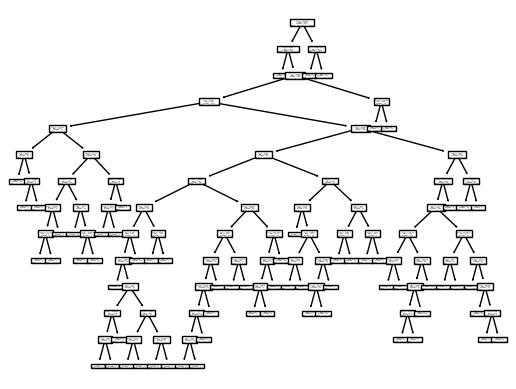

In [16]:
# Переглянемо структуру дерева
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plot_tree(rf_classifier.estimators_[0])
plt.show()